<a href="https://colab.research.google.com/github/allenbao64/csc2515-project/blob/main/goodreads_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import load_model

import io
from google.colab import files
uploaded = files.upload()

Saving reviews.pkl to reviews.pkl


In [ ]:
reviews = pd.read_pickle(io.BytesIO(uploaded['reviews.pkl']))

In [ ]:
reviews = reviews['review_sentences']
train, test = train_test_split(reviews, test_size=0.02)
# train = reviews[reviews['timestamp'] < '2015-01-01']
# train = train['review_sentences']
# test = reviews[reviews['timestamp'] >= '2015-01-01']
# test = test['review_sentences']
# test = test.sample(n=10000, random_state=1)

train_text = train.map(lambda x: x[1]).to_numpy()
train_labels = train.map(lambda x: x[0]).to_numpy().astype(np.int32)
test_text = test.map(lambda x: x[1]).to_numpy()
test_labels = test.map(lambda x: x[0]).to_numpy().astype(np.int32)


reviewMaxLen = 600

tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(train_text)
sequences = tokenizer.texts_to_sequences(train_text)
padded = pad_sequences(sequences, maxlen=reviewMaxLen)

In [ ]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 32, input_length=reviewMaxLen) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(32, dropout=0.1, return_sequences=True))
model.add(LSTM(32, dropout=0.2))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss='binary_crossentropy',optimizer=opt, metrics=[tf.keras.metrics.AUC()])

In [ ]:
history = model.fit(padded, train_labels, validation_split=0.2, epochs=3, batch_size=64, verbose=1)
model.save('model')

Epoch 1/3
7350/7350 [==============================] - 506s 69ms/step - loss: 0.1389 - auc: 0.6637 - val_loss: 0.1334 - val_auc: 0.7292
Epoch 2/3
7350/7350 [==============================] - 506s 69ms/step - loss: 0.1296 - auc: 0.7536 - val_loss: 0.1332 - val_auc: 0.7349
Epoch 3/3
7350/7350 [==============================] - 507s 69ms/step - loss: 0.1268 - auc: 0.7759 - val_loss: 0.1337 - val_auc: 0.7266
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/assets


In [ ]:
model = load_model('model')

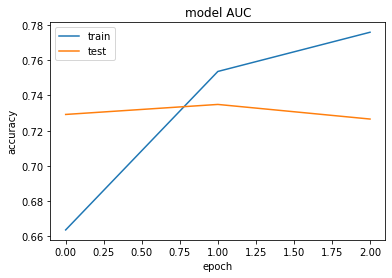

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = []
i = 0
for text in test_text:
    if i % 1000 == 0:
        print(i)
    i += 1
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=reviewMaxLen)
    prediction = model.predict(pad).item()
    predictions.append(prediction)
predictions = np.array(predictions)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions)
auc_keras = auc(fpr_keras, tpr_keras)

print(auc_keras)

0.7206748348855354
